In [1]:
import os
from pytorch_lightning import loggers as pl_loggers
import pytorch_lightning as pl
from image_inpainting.datamodule.image_net_data_module import ImageNetDataModule
from pytorch_lightning.callbacks import ModelCheckpoint
from image_inpainting.model.context_encoder import ContextEncoder
from image_inpainting.utils import print_results_images

In [2]:
from datetime import datetime
now = datetime.now()
now = now.strftime("%Y-%m-%d_%H-%M-%S")

## Create datamodule

In [3]:
data_dir = "data"

dm = ImageNetDataModule(
    data_dir=os.path.join(data_dir, "imagenet-128"), 
    batch_size_train=512,
    batch_size_val=512,
    batch_size_test=512,
    num_workers=10, 
    pin_memory=True, 
    persistent_workers=True
)

## Create a ContextEncoder model from scratch

In [4]:
model = ContextEncoder(input_size=(3, 128, 128), hidden_size=4000, save_image_per_epoch=True, reconstruction_loss_weight = 0.995, adversarial_loss_weight = 0.005)

## Or load it from a checkpoint

In [ ]:
# model = ContextEncoder.load_from_checkpoint("checkpoints/imagenet_128_200_factor_losses_coefficients/2024-12-19_16-47-18-epoch=17-val_loss=0.55.ckpt") # change the path to your checkpoint
# model.enable_save_image_per_epoch()
# model.to("cuda")

## Train it

In [5]:
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints/imagenet_128_200_factor_losses_coefficients_batch_512',
    filename=now+'-{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    save_top_k=-1,  # Save all checkpoints
    every_n_epochs=1  # Save checkpoint every n epochs
)

tb_logger = pl_loggers.TensorBoardLogger("Context_Encoder_Inpainting")
trainer = pl.Trainer(max_epochs=300, devices=-1, accelerator="cuda", logger=tb_logger, callbacks=[checkpoint_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, dm)

# To continue training:
# trainer.fit(model, dm, ckpt_path="checkpoints/imagenet_128_200_factor_losses_coefficients_batch_512/2024-12-18_12-08-15-epoch=01-val_loss=0.52.ckpt")

A notebook "tensorboard" exists if you want to check how the metrics evolve during training

## Results on the last epoch

Here the results of this cell are after 18 epochs on the full Image Net dataset cropped and resized to 128x128.

- **Number of steps**: 41 500
- **Time**: 6h30
- **Observations (with tensorboard)**: With a larger factor we have better results, as we can see when we compare to 100 factor results

In [6]:
trainer.test(model, dm)

You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Note: The ImageNet dataset can't be downloaded automatically. Please refer to the README if you haven't already downloaded it. Otherwise you can skip this message.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 196/196 [00:26<00:00,  7.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Final PSNR           13.403757095336914
        test_loss           0.5287359952926636
        test_psnr           13.403505325317383
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_psnr': 13.403505325317383,
  'test_loss': 0.5287359952926636,
  'Final PSNR': 13.403757095336914}]

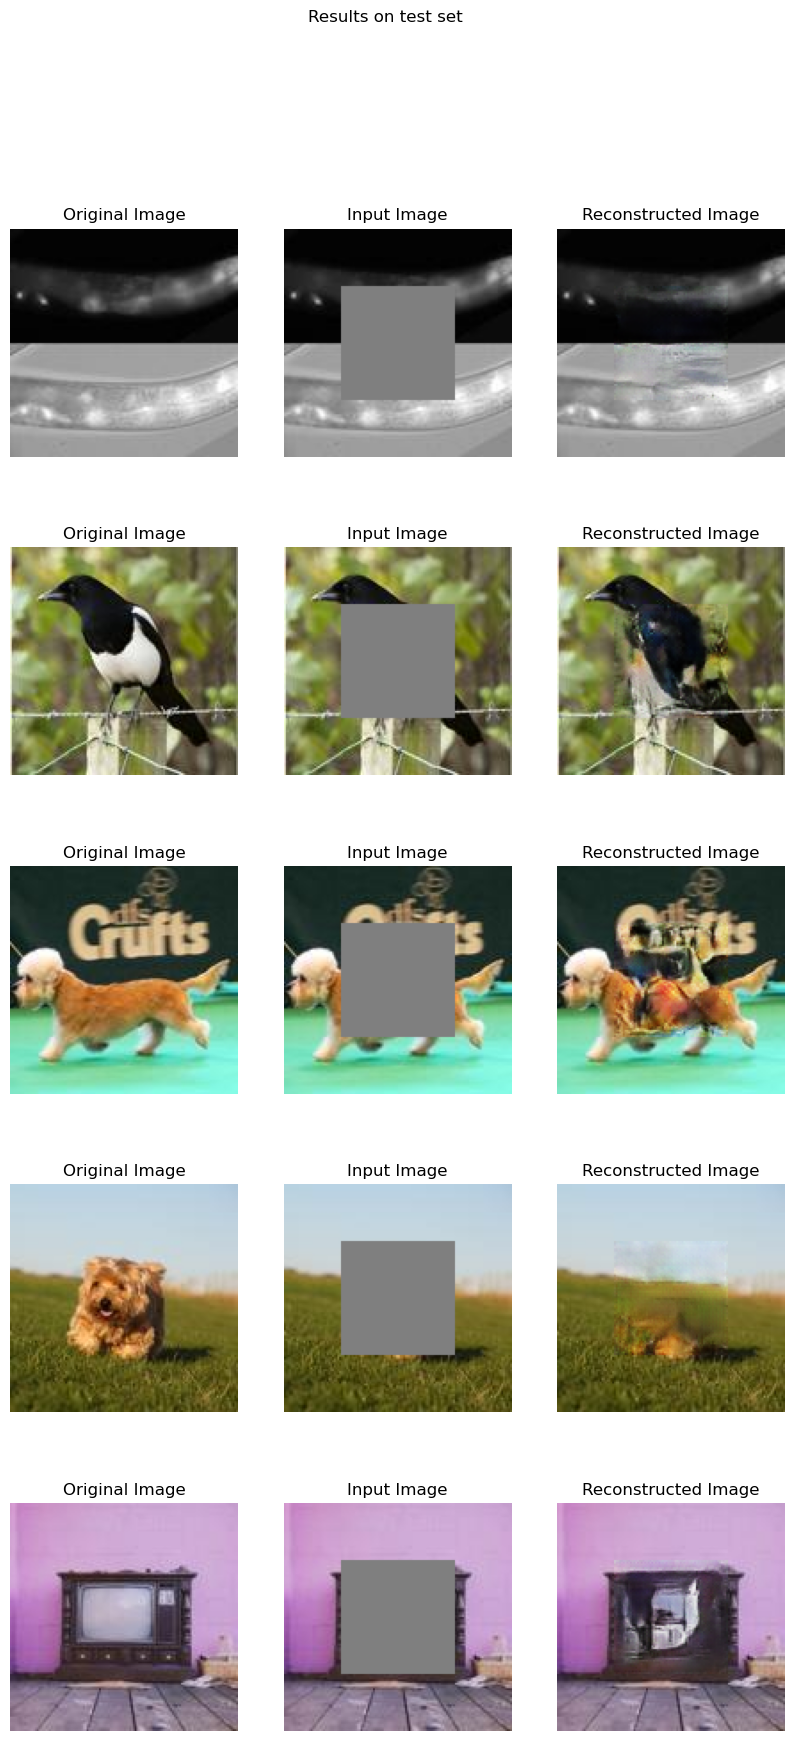

In [7]:
dm.setup("test") # in case "test" wasn't called before this cell

x, y = next(iter(dm.test_dataloader()))
x = x.to(model.device)
y = y.to(model.device)

out = model.forward(x)

print_results_images(x, y, out, "Results on test set", dm.inverse_transform)

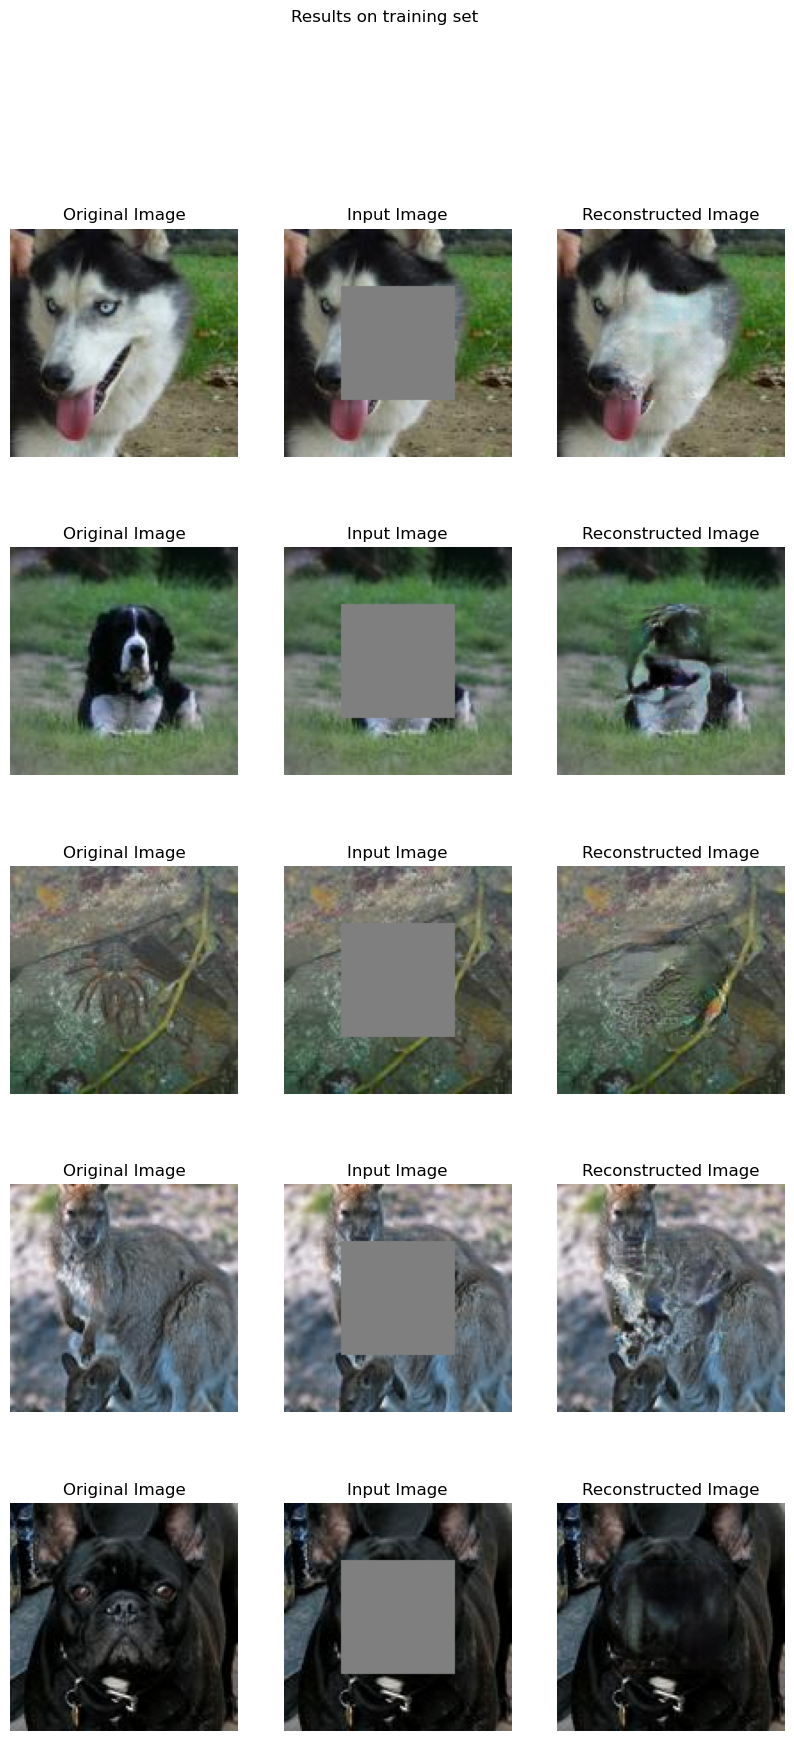

In [8]:
dm.setup("fit") # in case "fit" wasn't called before this cell

x, y = next(iter(dm.train_dataloader()))
x = x.to(model.device)
y = y.to(model.device)
out = model.forward(x)

print_results_images(x, y, out, "Results on training set", dm.inverse_transform)

This time the validation loss didn't change much so the results with lowest val loss won't be better, but you can load the checkpoint or check the tensorboard logs if you want